<a href="https://colab.research.google.com/github/LauJohansson/AnomalyDetection_VAE_LSTM/blob/master/VAE_LSTM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Variational autoencoder
*Authors: Jonas Søbro Christophersen & Lau Johansson*


# Importing and data preparation

## Import

In [0]:
from __future__ import print_function
import argparse

import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
from sklearn.decomposition import PCA
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import normalize 

torch.cuda.empty_cache()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#Set seed
torch.manual_seed(0)

#Function to test memory usage
def print_memory(a):
  print("Tensor is using {} MB memory.".format(a.element_size() * a.nelement() * 1e-6 ))

## Flags
This namespace contains all hyperparameters for the model

In [2]:
# Flags for the model
flags = argparse.Namespace(
    print_every=1, #lower value, more often test/train loss print. Based on epoch
    lstm_size = 128,
    latent_size = 20,
    input_size = 2, # 
    learning_rate = 1e-2,
    seq_size = 150,
    n_lay = 1,
    batch_size = 5,
    print_interval = 2,
    epochs = 8,
    number_of_noisy_obs=5,
    lambda_kl=0, #tune the prior? fit data vs. fit prior. Prior is zero mean gussian. try to set it to 0
    lambda_max=1,
    lambda_update_rate=0.1,
    num_of_directions=2,
    attention_size=2,
    optimizer_choice='AdamW', #AdamW , #SGD
    mode = "online small data", #"online small/big data"
    number_of_data_files=1000,
    pickle='Yes', #No
    standardize = "Yes",
    save_bad_img="No", #Yes
    Ntrainpoints = 5000,
    Ntestpoints = 1000,
    eta=0.01,
    L=20
) 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Loading data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

####### LOAD NEW DATA

if (flags.pickle!='Yes'):
  if flags.mode == "online big data":
    # Load data
    #https://lab.compute.dtu.dk/02460F20-tsad/shared

    import glob
    from scipy.io import loadmat

    # Load files for given cases only
    input_dir = 'drive/My Drive/Advanced Machine Learning/data/Lira/Synth_data_20042020_speed40/'
    #min_index = 7000
    #max_index = 18000
    file_pattern = '{0}*.mat'.format(input_dir)

    # Load data from mat files into python dictionary
    data = {}
    print('Loading data....')
    i=1
    for filename in glob.glob(file_pattern):
        i=i+1
        if(i==flags.number_of_data_files):
          break;
        
        #print('Loading file: {0}'.format(filename))
        defect_type = filename.split('_')[-3] # changed to -3 from -2

        # Get variables
        f = loadmat(filename)
        acc = f['acceleration'][:,:].reshape(1,-1)
        time = f['time'][:,:].reshape(1,-1)
        label = f['type'][:,:].reshape(1,-1)
        severity = f['severity'][:,:].reshape(1,-1)

        # Update dictionary with the data from this file
        data[filename] = {'time':time, 'acc':acc, 'true_labels':label, 'severity':severity, 'defect':defect_type}
    print('Loading finished.')
    list_of_filenames = list(data.keys())

  ##############################################################################

  if flags.mode == "online small data":
    # Load data
    #https://lab.compute.dtu.dk/02460F20-tsad/shared

    import glob
    from scipy.io import loadmat

    from google.colab import drive

    drive.mount('/content/drive')

    # Load files for given cases only
    input_dir = 'drive/My Drive/Advanced Machine Learning/data/Lira/Synt_data_20052019/'
    min_index = 7000
    max_index = 18000
    file_pattern = '{0}*.mat'.format(input_dir)

    # Load data from mat files into python dictionary
    data = {}
    print('Loading files...')
    for filename in glob.glob(file_pattern):
        #print('Loading file: {0}'.format(filename))
        defect_type = filename.split('_')[-2]

        # Get variables
        f = loadmat(filename)
        acc = f['acceleration'][min_index:max_index,:].reshape(1,-1)
        time = f['time'][min_index:max_index,:].reshape(1,-1)
        label = f['type'][min_index:max_index,:].reshape(1,-1)
        severity = f['severity'][min_index:max_index,:].reshape(1,-1)

        # Update dictionary with the data from this file
        data[filename] = {'time':time, 'acc':acc, 'true_labels':label, 'severity':severity, 'defect':defect_type}

    list_of_filenames = list(data.keys())
    print('Loading done!')

  ###############################################################################
  if flags.mode == "local":
    import glob
    from scipy.io import loadmat

    # Load files for given cases only
    input_dir = 'D:/DataForProgramming/lira/data/Lira/Synt_data_20052019/'
    min_index = 7000
    max_index = 18000
    file_pattern = '{0}*.mat'.format(input_dir)

    # Load data from mat files into python dictionary
    data = {}
    print('Loading files...')
    for filename in glob.glob(file_pattern):
        #print('Loading file: {0}'.format(filename))
        
        defect_type = filename.split('_')[-2]

        # Get variables
        f = loadmat(filename)
        acc = f['acceleration'][min_index:max_index,:].reshape(1,-1)
        time = f['time'][min_index:max_index,:].reshape(1,-1)
        label = f['type'][min_index:max_index,:].reshape(1,-1)
        severity = f['severity'][min_index:max_index,:].reshape(1,-1)

        # Update dictionary with the data from this file
        data[filename] = {'time':time, 'acc':acc, 'true_labels':label, 'severity':severity, 'defect':defect_type}
    print('Loading finish')
    list_of_filenames = list(data.keys())

if flags.pickle == "Yes":
  print('Pickle is used')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Pickle is used


### Data generator

In [4]:
if (flags.pickle!='Yes'):
  data_list = []
  # Get all crack data

  print('Generating...')
  for k in range(len(list_of_filenames)):
    if (flags.mode=='online small data'): #When small data online take crack
      if (data[list_of_filenames[k]]['defect'] == 'crack'):
        
        #selected every column and normalizing
        
        col1 = data[list_of_filenames[k]]['acc'][0]
        col2 = data[list_of_filenames[k]]['severity'][0]
        col3 = data[list_of_filenames[k]]['time'][0]  
        col4 = data[list_of_filenames[k]]['true_labels'][0]

        for l in range(flags.number_of_noisy_obs): # Add noisy observations
          noisy_col1 = col1 + np.random.normal(0,np.std(col1) / 5 ,len(col1))
          noisy_col2 = col2 + np.random.normal(0,np.std(col2) / 5 ,len(col2))
          data_list.append(([noisy_col1, noisy_col2, col3, col4]))

        data_list.append(([col1, col2, col3, col4])) # add original data
    else:
        col1 = normalize(data[list_of_filenames[k]]['acc'][0]) 
        col2 = normalize(data[list_of_filenames[k]]['severity'][0]) 
        col3 = data[list_of_filenames[k]]['time'][0] 
        col4 = data[list_of_filenames[k]]['true_labels'][0]

        for l in range(flags.number_of_noisy_obs): # Add noisy observations
          
          noisy_col1 = col1 + np.random.normal(0,np.std(col1) / 5 ,len(col1))
          
          noisy_col2 = col2 + np.random.normal(0,np.std(col2) / 5 ,len(col2))
          data_list.append(([noisy_col1, noisy_col2, col3, col4]))

        data_list.append(([col1, col2, col3, col4])) # add original data
  data_torch = torch.tensor(data_list)
  data_torch = data_torch.permute(2, 0, 1)
  data_torch = data_torch.float()
  data_torch=data_torch.to(device)
  print('Generation done!')

else:
  print('Pickle is used!')

Pickle is used!


## loading pickle instead

In [5]:
if (flags.pickle=='Yes'):
  # LOAD PRELOADED DATA
  print('Loading...')
  list_of_labels = torch.load('/content/drive/My Drive/Advanced Machine Learning/data/list_of_labels.pth')
  data_torch = torch.load('/content/drive/My Drive/Advanced Machine Learning/data/data_torch.pth')
  print('Loading done!')

Loading...
Loading done!


### Data train/test splitter

Shuffle data:

In [0]:
idxtorch = torch.randperm(len(list_of_labels))
lol = [list_of_labels[idx] for idx in idxtorch.tolist()]
list_of_labels = lol
data_torch = data_torch[:,idxtorch,:]

Check the dimension of the data:

In [7]:
#data_list has all data
print(data_torch.shape)

torch.Size([2778, 70128, 4])


Slicing data so it only has a sequence length of 500 and not long tails:

In [8]:
if (flags.pickle=='Yes' or flags.mode=='online big data'):
  start_slice=250 # 2000
  end_slice=400   #7000
  nm_p=1 #take every nm_p point

  train_batch_idx=flags.Ntrainpoints#40
  test_batch_idx=flags.Ntestpoints #60 #(when small data)

  X_train=data_torch[start_slice:end_slice:nm_p, :train_batch_idx, :2] #only acceleration and severity
  X_test=data_torch[start_slice:end_slice:nm_p, train_batch_idx:train_batch_idx+test_batch_idx, :2]

elif(flags.mode=='online small data'):
  start_slice= 2000
  end_slice=7000
  nm_p=10 #take every nm_p point

  train_batch_idx=40
  test_batch_idx=60 #(when small data)

  X_train=data_torch[start_slice:end_slice:nm_p,:train_batch_idx,:2] #only acceleration and severity
  X_test=data_torch[start_slice:end_slice:nm_p,train_batch_idx:test_batch_idx,:2]

else:
  raise Exception('Data not loaded properly')

print('The shape of X_train: {}'.format(X_train.shape))
print('The shape of X_test: {}'.format(X_test.shape))


The shape of X_train: torch.Size([150, 5000, 2])
The shape of X_test: torch.Size([150, 1000, 2])


# Standardize data

In [0]:
# Add a bit of noise to data to make standard deviations possible to find

if flags.standardize == "Yes":

  train_noise = torch.randn_like(X_train) * 0.001
  noisy_Xtrain = X_train + train_noise
  train_means = noisy_Xtrain.mean(dim=0, keepdim=True)
  train_stds = noisy_Xtrain.std(dim=0, keepdim=True)
  normalized_traindata = (noisy_Xtrain - train_means) / train_stds
  X_train = normalized_traindata

  test_noise = torch.randn_like(X_test) * 0.001
  noisy_Xtest = X_test + test_noise
  test_means = noisy_Xtest.mean(dim=0, keepdim=True)
  test_stds = noisy_Xtest.std(dim=0, keepdim=True)
  normalized_testdata = (noisy_Xtest - test_means) / test_stds
  X_test = normalized_testdata
  

### Plotting data

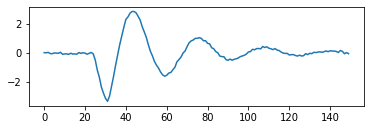

In [10]:
# Plot true data (0 is acceleration)
plt.subplot(2,1,1)
plt.plot((X_train[:,0,:][:,0]).cpu().detach().numpy())
plt.show()

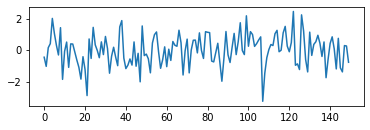

In [11]:
# Plot true data (1 is seveiry)
plt.subplot(2,1,1)
plt.plot((X_train[:,0,:][:,1]).cpu().detach().numpy())
plt.show()

# The Model

In [0]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.seq_size = flags.seq_size
        self.lstm_size = flags.lstm_size
        self.latent_size = flags.latent_size
        self.attention_size=flags.attention_size
        self.input_size = flags.input_size
        self.batch_size = flags.batch_size
        self.num_layers = flags.n_lay
        self.directions=flags.num_of_directions
        self.batch_norm=nn.BatchNorm1d(self.input_size)
        self.softmax = nn.Softmax(dim=0)
        self.SoftP=nn.Softplus()

        #Encoder lstm:
        self.encoder1 = nn.LSTM(self.input_size, self.lstm_size, self.num_layers, bidirectional = True)

        #Linear from encoder to variational layer
        self.encoder_mu = nn.Linear(self.lstm_size* self.directions, self.latent_size) 
        self.encoder_logvar = nn.Linear(self.lstm_size *self.directions, self.latent_size)
        
        #Attention to decoder
        #Mean and variance linear layer for transforming c_det ----->  to c_t
        self.encoder_att_mu = nn.Linear( self.lstm_size * self.directions ,  self.attention_size )
        self.encoder_att_logvar = nn.Linear(self.lstm_size * self.directions ,  self.attention_size )
         
        #Decoder lstm
        self.decoder1 = nn.LSTM(self.latent_size + self.attention_size, self.lstm_size, self.num_layers, bidirectional = True) #*2 because z and c has same dimension

        #Linear from decoder lstm to output
        self.reconstruction_mu = nn.Linear( self.lstm_size * self.directions, self.input_size)
        self.reconstruction_logvar = nn.Linear( self.lstm_size * self.directions, self.input_size)

    def encode(self, x):       
        #Pass input to encoder lstm  
        output_encoder, (h_n,c_n) = self.encoder1(x)

        #Tanh activation on lstm last hidden
        h1=torch.cat((h_n[0,:,:], h_n[1,:,:]), 1)   # ONLY WORKS IF BIDIRECTIONAL
        
        #Return encoded mu and logvar ( with softplus) ready to variational-layer. Returning output ready to "attention-layer"
        return self.encoder_mu(torch.tan(h1)), self.SoftP(self.encoder_logvar(torch.tan(h1))), output_encoder 

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std) #randn_like -> mean 0 and standarddeviation 1. Dimension same as "std"
        return mu + eps*std
        
    def attention(self, out_encoder):
        # Compute score S atrix s11, s12, ... sTT and A scores.
        for batch_idx in range(self.batch_size):
           
            if batch_idx == 0:
                s_tensor = torch.div(torch.matmul(out_encoder[:,batch_idx,:], (out_encoder[:,batch_idx,:]).t()) , np.sqrt(self.lstm_size * self.directions))
                a_tensor = self.softmax(s_tensor)  
                del s_tensor
                c_det = (a_tensor.unsqueeze(1) * out_encoder[:,batch_idx,:].unsqueeze(2)).sum(dim=2)
                c_det = c_det.unsqueeze(1)
            else:
                s_score = ((torch.mm(out_encoder[:,batch_idx,:], (out_encoder[:,batch_idx,:]).t())) / np.sqrt(self.lstm_size * self.directions))
                a_score = self.softmax(s_score)
                del s_score
                a_tensor = torch.cat((a_tensor, a_score), 1)
                c_det_batch = (a_tensor.unsqueeze(1) * out_encoder[:,batch_idx,:].unsqueeze(2)).sum(dim=2)
                c_det_batch = c_det_batch.unsqueeze(1)
                c_det = torch.cat((c_det, c_det_batch), 1)
        return c_det

    def decode(self, z, c):
        zrep = z.unsqueeze(0).repeat(self.seq_size, 1, 1)

         # Concatenate z and c
        zandc = torch.cat((zrep,c), 2)

        #Pass z and c to decoder lstm
        output_decoder, state_decoder = self.decoder1(zandc)

        return self.reconstruction_mu(torch.tan(output_decoder)),self.SoftP(self.reconstruction_logvar(torch.tan(output_decoder))),  state_decoder #NEW LAU 4 maj
        
    def forward(self, x):  
        #Encode-layer
        mu, logvar, output_encoder = self.encode(x)
        
        
        #Attention-layer
        c_det = self.attention(output_encoder)
 
        #Attention to decoder.     Pass each c_det one at a time.
        for t in range(flags.seq_size):
            if (t==0):
              c_0= c_det[t,:,:]
              c_0 = c_0.unsqueeze(0)
              c_t_mu=self.encoder_att_mu(c_0)
              c_t_mus=c_t_mu
              c_t_logvar=self.SoftP(self.encoder_att_logvar(c_0))
              c_t_logvars=c_t_logvar
              c_final=self.reparameterize(c_t_mu, c_t_logvar)
              del c_0
            else:
              c_current= c_det[t,:,:]
              c_current = c_current.unsqueeze(0)

              c_t_mu=self.encoder_att_mu(c_current)

              c_t_logvar=self.SoftP(self.encoder_att_logvar(c_current))
              c_final=torch.cat((c_final,self.reparameterize(c_t_mu, c_t_logvar)),0)

              c_t_mus = torch.cat((c_t_mu, c_t_mus), 0) # NY
              c_t_logvars = torch.cat((c_t_logvar, c_t_logvars), 0) # NY

      
        #"Variational layer"
        
        if (self.training==True):
          z= self.reparameterize(mu, logvar)
              

          output_mu,output_logvar, state_decoder = self.decode(z, c_final)
        
    
          #output=self.reparameterize(output_mu,output_logvar)
          output=output_mu


          return output, mu, logvar, output_encoder, state_decoder, c_det, z, c_final,c_t_mus,c_t_logvars,output_mu

        if (self.training==False):
          for l in range(flags.L):
            
            z= self.reparameterize(mu, logvar)
            if(l==0):
              output_mu,output_logvar, state_decoder = self.decode(z, c_final)
        
    
            #output=self.reparameterize(output_mu,output_logvar)
              output_all=output_mu.unsqueeze(0)
              output=output_mu
            else:
              output_mu,output_logvar, state_decoder = self.decode(z, c_final)
              output_all=torch.cat((output_all,output_mu.unsqueeze(0)),0)

          return output, mu, logvar, output_encoder, state_decoder, c_det, z, c_final,c_t_mus,c_t_logvars,output_mu,output_all
    
   

## Init model

In [0]:
torch.backends.cudnn.enabled = False
model = VAE().to(device)

## Optimizer

In [0]:
if (flags.optimizer_choice=='AdamW'):
  optimizer = optim.AdamW(model.parameters(), lr = flags.learning_rate)
elif(flags.optimizer_choice=='SGD'):
  optimizer = optim.SGD(model.parameters(), lr = flags.learning_rate)
else: 
  optimizer = optim.Adam(model.parameters(), lr = flags.learning_rate)

## Test model 

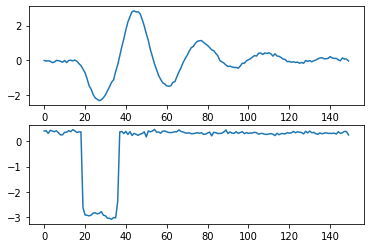

In [133]:
model.train()
output, _, _, _, _, _,_,_,c_t_mus,c_t_logvars,output_mu = model(X_train[:,0:flags.batch_size,:])
# Compare true data with reconstructed data (0 is acceleration)
plt.subplot(2,1,1)
plt.plot((X_train[:,1,:][:,0]).cpu().detach().numpy())
plt.subplot(2,1,2)
plt.plot((output[:,1,:][:,1]).cpu().detach().numpy())
plt.show()

# Functions




## Loss

In [0]:
#https://github.com/GauravBh1010tt/DL-Seq2Seq/blob/master/variational%20autoencoders%20(VAE%2C%20CVAE)/vae.py
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar,lamb, mu_att, logvar_att):
    #BCE = F.binary_cross_entropy(recon_x, x.view(-1, flags.seq_size), reduction='sum')
    CE = F.mse_loss(recon_x, x, reduction='sum')

    # J. Pereira, "Thesis - Unsupervised Anomaly Detection in Time Series Data using Deep Learning" page 90 (equation 12)
    KLD = lamb*(-0.5) * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())


    KLD_attention = lamb*flags.eta*(-0.5) * torch.sum(1 + logvar_att - mu_att.pow(2) - logvar_att.exp())

    return CE + KLD + KLD_attention

## Get batches

In [0]:
# Get batches
def get_batches(iterable, n = flags.batch_size):
    l = iterable.shape[1]   # Number of total samples (48)
    for ndx in range(0, l, n):
        yield iterable[:,ndx:min(ndx + n, l),:]

## Train model

In [0]:
def train(epoch,lambda_kl):
    model.train()
    train_loss = 0
  
    batches = get_batches(X_train)
    for trainbatch in batches:
        trainbatch = trainbatch.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, _, _, _,_,_,c_t_mus,c_t_logvars,output_mu = model(trainbatch)
        loss = loss_function(recon_batch, trainbatch, mu, logvar,lambda_kl,c_t_mus,c_t_logvars)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    if (epoch % flags.print_every == 0):
      print('Train loss: {:.4f}'.format(train_loss / X_train.shape[1]))
    
    return train_loss / X_train.shape[1]


## Test model

In [0]:
def test(epoch,lambda_kl):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        batches = get_batches(X_test)
        for testbatch in batches:
        
          testbatch = testbatch.to(device)
          recon_batch, mu, logvar, _, _, _,_,_,c_t_mus,c_t_logvars,output_mu,_ = model(testbatch)
          loss = loss_function(recon_batch, testbatch, mu, logvar,lambda_kl,c_t_mus,c_t_logvars)
          test_loss += loss.item()

    test_loss /= X_test.shape[1]
    if (epoch % flags.print_every == 0):
      print('Test loss: {:.4f}'.format(test_loss))
    return test_loss

# Main

Epoch 1 / 8
Test loss: 300.9102
Train loss: 18.5720
Epoch 1 running time 0:08:14.732013:
Epoch 2 / 8
Test loss: 67.2846
Train loss: 17.9545
Epoch 2 running time 0:08:18.278052:
Epoch 3 / 8
Test loss: 19.4822
Train loss: 18.1969
Epoch 3 running time 0:08:14.864846:
Epoch 4 / 8
Test loss: 19.3781
Train loss: 20.5013
Epoch 4 running time 0:08:17.787032:
Epoch 5 / 8
Test loss: 22.3635
Train loss: 22.0750
Epoch 5 running time 0:08:23.908936:
Epoch 6 / 8
Test loss: 23.4714
Train loss: 22.7924
Epoch 6 running time 0:08:16.962498:
Epoch 7 / 8
Test loss: 24.3132
Train loss: 22.4263
Epoch 7 running time 0:08:15.816398:
Epoch 8 / 8
Test loss: 28.5534
Train loss: 26.9004
Epoch 8 running time 0:08:10.167512:
Total running time 1:06:12.518322


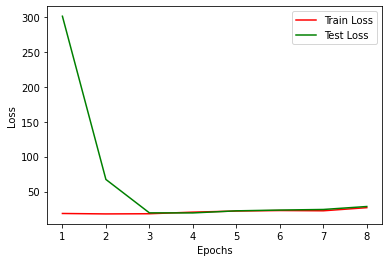

In [21]:
if __name__ == "__main__":
    tic_total= datetime.now()
    epochnumber = []
    all_train_losses = []
    all_test_losses = []
    lambda_update=flags.lambda_kl

    for epoch in range(1, flags.epochs + 1):
        tic = datetime.now()
        epochnumber.append(epoch)
        print("Epoch {} / {}".format(epoch,flags.epochs))
        
        #For plotting purpose the order of train and test are reversed
        all_test_losses.append(test(epoch,lambda_update))
        all_train_losses.append(train(epoch,lambda_update))
      
        print("Epoch {} running time {}:".format(epoch,datetime.now() - tic))
        
         #update lambda
        if (lambda_update<flags.lambda_max):
           lambda_update+=flags.lambda_update_rate
    print("Total running time {}".format(datetime.now() - tic_total))
    
    plt.figure(1)                             
    plt.xlabel('Epochs'), plt.ylabel('Loss')   
    plt.plot(epochnumber, all_train_losses, 'r', epochnumber, all_test_losses, 'g')
    plt.legend(['Train Loss', 'Test Loss'])
     

In [0]:
torch.save(model.state_dict(), 'drive/My Drive/Advanced Machine Learning/model_saved_14may_1900')

In [0]:

#plt.figure(2)                             
#plt.xlabel('Epochs'), plt.ylabel('Loss')   
#plt.plot(epochnumber[-6:], all_train_losses[-6:], 'r', epochnumber[-6:], all_test_losses[-6:], 'g')
#plt.legend(['Train Loss', 'Test Loss'])

# Testing output

Text(0.5, 0, 'Timestep')

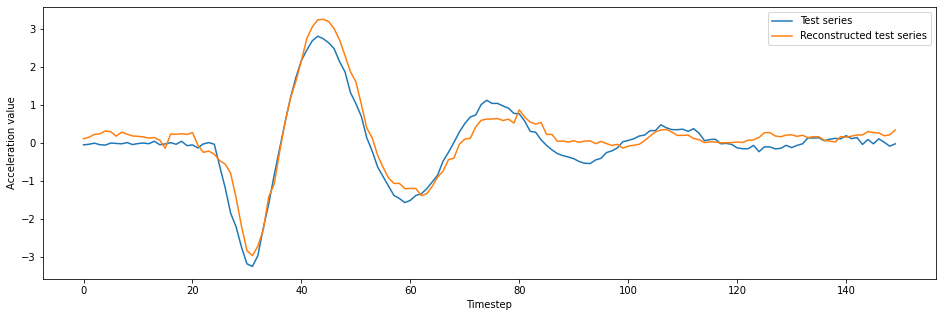

In [24]:
model.eval()
output_good, mu_good, logvar_good, output_encoder, state_decoder, c_det_to_pca, z_good, c_final_good,c_t_mus,c_t_logvars,output_mu_good,output_all = model(X_test[:,0:flags.batch_size,:])
# Compare true data with reconstructed data (0 is acceleration)

plt.figure(figsize=(16,5))
plt.plot((X_test[:,0,:][:,0]).cpu().detach().numpy())
plt.plot((output_good[:,0,:][:,0]).cpu().detach().numpy())
plt.legend(["Test series", "Reconstructed test series"])
plt.ylabel("Acceleration value")
plt.xlabel("Timestep")

Text(0.5, 0, 'Timestep')

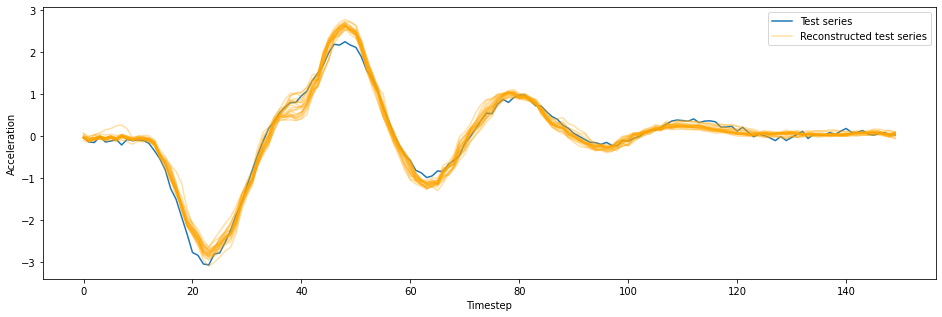

In [98]:
plt.figure(figsize=(16,5))
plt.plot((X_test[:,1,:][:,0]).cpu().detach().numpy())
for i in range(flags.L):
  plt.plot((output_all[i,:,1,:][:,0]).cpu().detach().numpy(),color='Orange',alpha=0.35)
plt.legend(["Test series", "Reconstructed test series"])
plt.ylabel("Acceleration")
plt.xlabel("Timestep")

In [99]:
mse_loss=0
for i in range(flags.L):
  mse_loss+=F.mse_loss(output_all[i,:,1,:],X_test[:,1,:], reduction='sum')

print(mse_loss/flags.L)

tensor(6.5648, device='cuda:0', grad_fn=<DivBackward0>)


### Choose specific defect type and test 

In [0]:
#choose='crack'
#choose='patch'
choose='pothole'

In [30]:
  # Load data
    #https://lab.compute.dtu.dk/02460F20-tsad/shared

import glob
from scipy.io import loadmat

from google.colab import drive

drive.mount('/content/drive')

# Load files for given cases only
input_dir = 'drive/My Drive/Advanced Machine Learning/data/Lira/Synt_data_20052019/'
min_index = 7000
max_index = 18000
file_pattern = '{0}*.mat'.format(input_dir)

# Load data from mat files into python dictionary
data = {}
print('Loading files...')
for filename in glob.glob(file_pattern):
    #print('Loading file: {0}'.format(filename))
    defect_type = filename.split('_')[-2]

    # Get variables
    f = loadmat(filename)
    acc = f['acceleration'][min_index:max_index,:].reshape(1,-1)
    time = f['time'][min_index:max_index,:].reshape(1,-1)
    label = f['type'][min_index:max_index,:].reshape(1,-1)
    severity = f['severity'][min_index:max_index,:].reshape(1,-1)

    # Update dictionary with the data from this file
    data[filename] = {'time':time, 'acc':acc, 'true_labels':label, 'severity':severity, 'defect':defect_type}

list_of_filenames = list(data.keys())
print('Loading done!')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading files...
Loading done!


In [0]:
data_specific_defect_list = []
# Get all crack data
 
for k in range(len(list_of_filenames)):
  if (data[list_of_filenames[k]]['defect'] == choose):
    col1 = data[list_of_filenames[k]]['acc'][0]
    col2 = data[list_of_filenames[k]]['severity'][0]
    col3 = data[list_of_filenames[k]]['time'][0] 
    col4 = data[list_of_filenames[k]]['true_labels'][0]
 
    for l in range(flags.number_of_noisy_obs): # Add noisy observations
      noisy_col1 = col1 + np.random.normal(0,np.std(col1) / 5 ,len(col1))
      noisy_col2 = col2 + np.random.normal(0,np.std(col2) / 5 ,len(col2))
      data_specific_defect_list.append(([noisy_col1, noisy_col2, col3, col4]))
  
    data_specific_defect_list.append(([col1, col2, col3, col4])) # add original data
  
data_specific_defect_torch = torch.tensor(data_specific_defect_list)
data_specific_defect_torch = data_specific_defect_torch.permute(2, 0, 1)
data_specific_defect_torch = data_specific_defect_torch.float()
data_specific_defect_torch=data_specific_defect_torch.to(device)

In [32]:
start_slice= 2000
end_slice=7100
nm_p=34 #take every nm_p point

train_batch_idx=40
test_batch_idx=60 #(when small data)

X_train_specific=data_specific_defect_torch[start_slice:end_slice:nm_p,:train_batch_idx,:2] #only acceleration and severity
X_test_specific=data_specific_defect_torch[start_slice:end_slice:nm_p,train_batch_idx:test_batch_idx,:2]

print('The shape of X_train: {}'.format(X_train_specific.shape))
print('The shape of X_test: {}'.format(X_test_specific.shape))

The shape of X_train: torch.Size([150, 40, 2])
The shape of X_test: torch.Size([150, 8, 2])


In [0]:
# Add a bit of noise to data to make standard deviations possible to find
 
if flags.standardize == "Yes":
 
  train_noise_specific = torch.randn_like(X_train_specific) * 0.001
  noisy_Xtrain_specific = X_train_specific + train_noise_specific
  train_means_specific = noisy_Xtrain_specific.mean(dim=0, keepdim=True)
  train_stds_specific = noisy_Xtrain_specific.std(dim=0, keepdim=True)
  normalized_traindata_specific = (noisy_Xtrain_specific - train_means_specific) / train_stds_specific
  X_train_specific = normalized_traindata_specific
 
  test_noise_specific = torch.randn_like(X_test_specific) * 0.001
  noisy_Xtest_specific = X_test_specific + test_noise_specific
  test_means_specific = noisy_Xtest_specific.mean(dim=0, keepdim=True)
  test_stds_specific = noisy_Xtest_specific.std(dim=0, keepdim=True)
  normalized_testdata_specific = (noisy_Xtest_specific - test_means_specific) / test_stds_specific
  X_test_specific = normalized_testdata_specific
else:
  for i in range(X_train.shape[1]):
    for j in range(X_train.shape[2]):
      mini=X_train[:,i,j].min()
      maxi=X_train[:,i,j].max()
      X_train[:,i,j]=2*((X_train[:,i,j]-mini)/(maxi-mini))-1

  for i in range(X_test.shape[1]):
    for j in range(X_test.shape[2]):
      mini=X_test[:,i,j].min()
      maxi=X_test[:,i,j].max()
      X_test[:,i,j]=2*((X_test[:,i,j]-mini)/(maxi-mini))-1

Text(0.5, 0, 'Timestep')

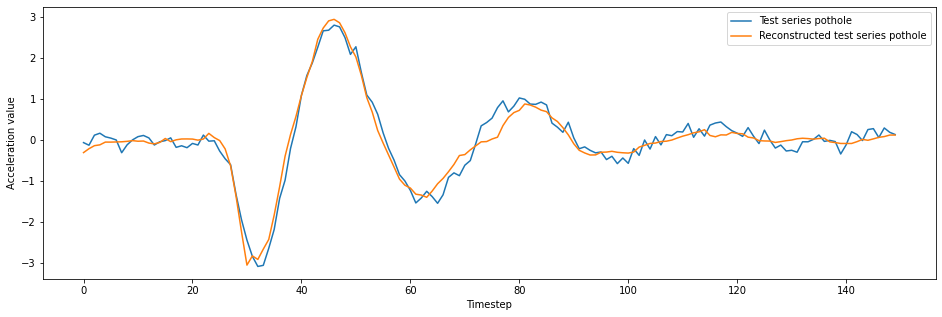

In [34]:
model.eval()

output_specific, mu_specific, logvar_specific, output_encoder_specific, state_decoder_specific,c_det_to_pca_specific, z_specific, c_final_specific,c_t_mus_specific,c_t_logvars_specific,output_mu_specific,output_all_specific = model(X_test_specific[:,0:flags.batch_size,:])
# Compare true data with reconstructed data (0 is acceleration)

plt.figure(figsize=(16,5))
plt.plot((X_test_specific[:,0,:][:,0]).cpu().detach().numpy())
plt.plot((output_specific[:,0,:][:,0]).cpu().detach().numpy())
plt.legend(["Test series "+str(choose), "Reconstructed test series "+str(choose)])
plt.ylabel("Acceleration value")
plt.xlabel("Timestep")


### Give anomalous inputs

**Acceleration anomaly 1**

In [35]:
'''
Bad input 1:
bad_name=1
X_bad=X_test[:,0:flags.batch_size,:].data.clone() + nn.functional.relu((X_test[:,flags.batch_size:flags.batch_size*2,:].data.clone()))*3
'''

'''
#Bad input 1.1:
bad_name=1
X_bad=X_test[:,0:flags.batch_size,:].data.clone()
X_bad[180:200,0,0]=X_bad[180:200,0,0]*3
'''
'''
#Bad input 1.2:
bad_name=1
X_bad=X_test[:,0:flags.batch_size,:].data.clone()
X_bad[200:230,0,0]=X_bad[200:230,0,0]
'''


'\n#Bad input 1.2:\nbad_name=1\nX_bad=X_test[:,0:flags.batch_size,:].data.clone()\nX_bad[200:230,0,0]=X_bad[200:230,0,0]\n'

**Acceleration anomaly 2**

In [0]:
#Weird input 2:
#bad_name=2
#X_bad=X_test[:,0:flags.batch_size,:].data.clone() * torch.randn(150,5,2).to(device)

**Acceleration anomaly 3**

In [37]:
'''
# bad input 3:
bad_name=3
X_bad=X_test[:,0:flags.batch_size,:].data.clone()
X_bad[200:400,0,0]=torch.FloatTensor(list(np.ones(200)*10))
X_bad[200:400,1,0]=torch.FloatTensor(list(np.ones(200)*10))
X_bad[200:400,2,0]=torch.FloatTensor(list(np.ones(200)*10))
X_bad[200:400,3,0]=torch.FloatTensor(list(np.ones(200)*10))

'''

'\n# bad input 3:\nbad_name=3\nX_bad=X_test[:,0:flags.batch_size,:].data.clone()\nX_bad[200:400,0,0]=torch.FloatTensor(list(np.ones(200)*10))\nX_bad[200:400,1,0]=torch.FloatTensor(list(np.ones(200)*10))\nX_bad[200:400,2,0]=torch.FloatTensor(list(np.ones(200)*10))\nX_bad[200:400,3,0]=torch.FloatTensor(list(np.ones(200)*10))\n\n'

**Acceleration anomaly 4**

In [38]:
'''
# Bad input 4:
bad_name=4
bad=[]
x1=range(50,100)
for i in range(len(x1)): 
  bad.append( np.cos(x1[i]/10)) #change here

x2=range(100,150)
for i in range(len(x2)):
  #bad.append(-1) #change here
  bad.append( np.cos(x3[i]/10))

x3=range(150,200)
for i in range(len(x3)): 
  bad.append( np.cos(x3[i]/10)) #change here

X_bad=X_test[:,0:flags.batch_size,:].data.clone()
X_bad[50:200,0,0]=torch.FloatTensor(bad)
X_bad[50:200,1,0]=torch.FloatTensor(bad)
X_bad[50:200,2,0]=torch.FloatTensor(bad)
X_bad[50:200,3,0]=torch.FloatTensor(bad)
'''

'\n# Bad input 4:\nbad_name=4\nbad=[]\nx1=range(50,100)\nfor i in range(len(x1)): \n  bad.append( np.cos(x1[i]/10)) #change here\n\nx2=range(100,150)\nfor i in range(len(x2)):\n  #bad.append(-1) #change here\n  bad.append( np.cos(x3[i]/10))\n\nx3=range(150,200)\nfor i in range(len(x3)): \n  bad.append( np.cos(x3[i]/10)) #change here\n\nX_bad=X_test[:,0:flags.batch_size,:].data.clone()\nX_bad[50:200,0,0]=torch.FloatTensor(bad)\nX_bad[50:200,1,0]=torch.FloatTensor(bad)\nX_bad[50:200,2,0]=torch.FloatTensor(bad)\nX_bad[50:200,3,0]=torch.FloatTensor(bad)\n'

**Acceleration anomaly 5**

In [0]:
'''
#Weird input 5:
bad_name=5
X_bad=X_test[:,0:flags.batch_size,:].data.clone() 
X_bad[50:55,1,0]=torch.FloatTensor(list(np.ones(5)*3))
X_bad[120:122,1,0]=torch.FloatTensor(list(np.ones(2)*3))
'''

**Acceleration anomaly 6**

In [0]:
'''
#weird 6
bad_name=6
X_bad=X_test[:,0:flags.batch_size,:].data.clone()
bad=[]
x1=range(0,30)
for i in range(len(x1)): 
  bad.append( np.cos(x1[i])/10) #change here
X_bad[80:110,0,0]=torch.FloatTensor(bad)
'''

**Acceleration anomaly 7**

In [0]:

#Bad 7
bad_name=7
X_bad=X_test[:,0:flags.batch_size,:].data.clone()
bad=[]
x1=range(0,40)
for i in range(len(x1)): 
  bad.append( np.cos(x1[i]/10)*2) #change here
X_bad[60:100,1,0]=torch.FloatTensor(bad)


**Acceleration anomaly 8**

In [0]:
#weird 8
#bad_name=8
#X_bad=X_test[:,0:flags.batch_size,:].data.clone()
#X_bad[0:140,0,0]=X_bad[0:140,0,0]*(-1)


**Severity anomaly 1**

In [0]:
#bad_name='sev1'
#X_bad=X_test[:,0:flags.batch_size,:].data.clone()
#X_bad[20:30,1,1]=torch.FloatTensor(list(np.ones(10)*(-3)))

**Severity anomaly 2**

In [0]:
#bad_name='sev2'
#X_bad=X_test[:,0:flags.batch_size,:].data.clone()
#X_bad[50:55,1,1]=torch.FloatTensor(list(np.ones(5)*3))

In [0]:
model.eval()
output_bad, mu_bad, logvar_bad, lambda_kl_bad, _, c_det_bad,z_bad,c_final_bad,c_t_mus_bad,c_t_logvars_bad,output_mu_bad,output_all_bad = model(X_bad[:,0:flags.batch_size,:])


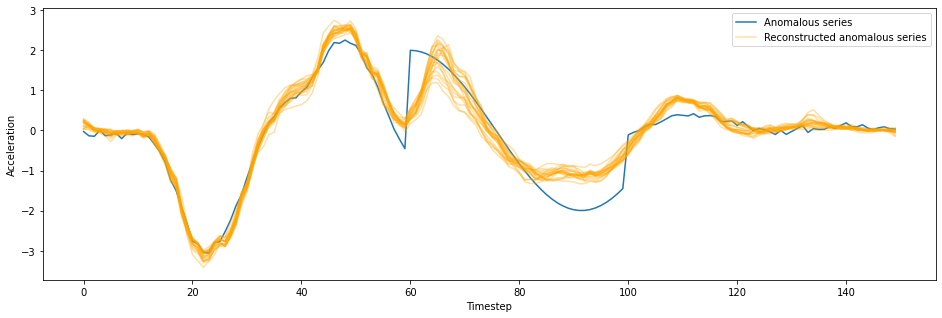

In [139]:
#print(torch.sum(torch.abs(output_bad - X_test[:,0:flags.batch_size,:])))
plt.figure(figsize=(16,5))
plt.plot((X_bad[:,1,:][:,0]).cpu().detach().numpy())
for i in range(flags.L):
  plt.plot((output_all_bad[i,:,1,:][:,0]).cpu().detach().numpy(),color='Orange',alpha=0.35)

plt.legend(["Anomalous series", "Reconstructed anomalous series"])
plt.ylabel("Acceleration")
plt.xlabel("Timestep")

#to save picture:
if (flags.save_bad_img=='Yes'):
  randnum=int(np.round(np.abs(np.random.normal()),decimals=4)*1000)
  plt.savefig('drive/My Drive/Advanced Machine Learning/bad'+str(bad_name)+'_'+'rand'+str(randnum)+'.png')

plt.show()


In [124]:
mse_loss=0
for i in range(flags.L):
  mse_loss+=F.mse_loss(output_all_bad[i,:,1,:],X_test[:,1,:], reduction='sum')

print(mse_loss/flags.L)

tensor(9.4003, device='cuda:0', grad_fn=<DivBackward0>)


# PCA

https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

# Visualize z-vectors, mu-values for z-vectors and context vectors (after reparameterization)

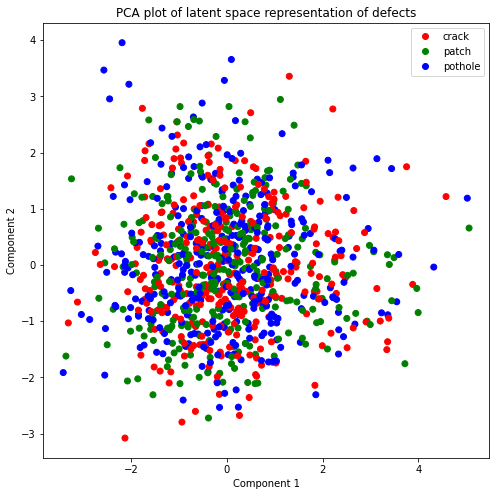

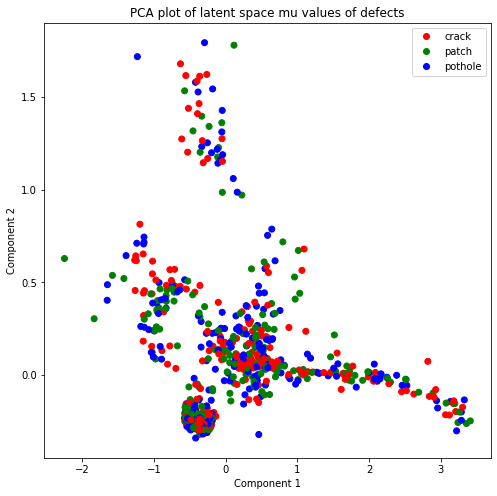

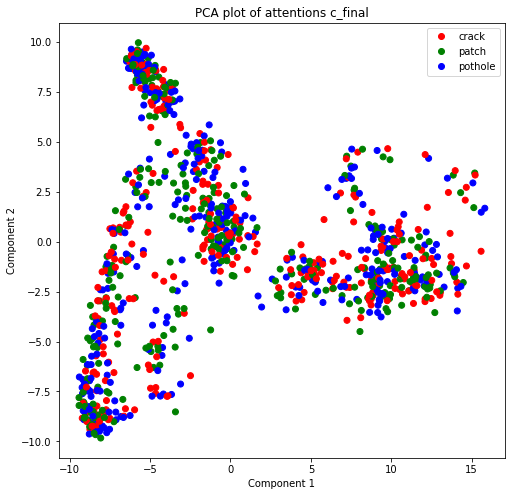

In [46]:
# Initialize a tensor to contain z's with first batch

output, mu, logvar, lambda_kl,_, c_det, z, c_final,c_t_mus_bad,c_t_logvars_bad,output_mu_bad,output_all_bad = model(X_test[:,0:flags.batch_size,:])
all_zs = z
all_mus = mu
all_cfinal = c_final

# Iterate over remaining X_test data batches and grab z-values
nrofbatches = X_test.shape[1] 
for batchnr in range(flags.batch_size, nrofbatches, flags.batch_size):
  output, mu, logvar, lambda_kl,_, c_det, z, c_final,c_t_mus_bad,c_t_logvars_bad,output_mu_bad,output_all_bad = model(X_test[:,batchnr:batchnr+flags.batch_size,:])
  all_zs = torch.cat((all_zs, z), 0)
  all_mus = torch.cat((all_mus, mu), 0)
  all_cfinal = torch.cat((all_cfinal, c_final), 1)

classes = list(np.unique(list_of_labels[0:X_test.shape[1]]))

mydict={}
i = 0
for item in classes:
    if(i>0 and item in mydict):
        continue
    else:    
      i = i+1
      mydict[item] = i
intclasses=[]
for item in list_of_labels:
    intclasses.append(mydict[item])


if flags.latent_size == 2:
  xz = all_zs[:,0].cpu().detach().numpy()
  yz = all_zs[:,1].cpu().detach().numpy()
  colors = ['red','green','blue'] # Add color if more classes come
  fig = plt.figure(figsize=(8,8))
  scatter = plt.scatter(xz, yz, c=intclasses[0:X_test.shape[1]], cmap=matplotlib.colors.ListedColormap(colors))
  plt.legend(handles=scatter.legend_elements()[0], labels=classes)
  plt.title("Scatter plot of latent space representation of defects")
  plt.xlabel("Latent space (z) value")
  plt.show()

  xmu = all_mus[:,0].cpu().detach().numpy()
  ymu = all_mus[:,1].cpu().detach().numpy()
  colors = ['red','green','blue'] # Add color if more classes come
  fig = plt.figure(figsize=(8,8))
  scatter = plt.scatter(xmu, ymu, c=intclasses[0:X_test.shape[1]], cmap=matplotlib.colors.ListedColormap(colors))
  plt.legend(handles=scatter.legend_elements()[0], labels=classes)
  plt.title("Scatter plot of latent space mu's representation of defects")
  plt.xlabel("Latent space mu value")
  plt.show()

if flags.latent_size == 1:
  xz = all_zs[:,0].cpu().detach().numpy()
  yz = torch.rand(len(xz))
  colors = ['red','green','blue'] # Add color if more classes come
  fig = plt.figure(figsize=(8,8))
  scatter = plt.scatter(xz, yz, c=intclasses[0:X_test.shape[1]], cmap=matplotlib.colors.ListedColormap(colors))
  plt.legend(handles=scatter.legend_elements()[0], labels=classes)
  plt.title("Jitter plot of latent space representation of defects")
  plt.xlabel("Latent space (z) value")
  plt.ylim(-4,4)
  plt.show()

  xmu = all_mus[:,0].cpu().detach().numpy()
  ymu = torch.rand(len(xmu))
  colors = ['red','green','blue'] # Add color if more classes come
  fig = plt.figure(figsize=(8,8))
  scatter = plt.scatter(xmu, ymu, c=intclasses[0:X_test.shape[1]], cmap=matplotlib.colors.ListedColormap(colors))
  plt.legend(handles=scatter.legend_elements()[0], labels=classes)
  plt.title("Jitter plot of mu latent space representation of defects")
  plt.xlabel("Latent space (mu) value")
  plt.ylim(-4,4)
  plt.show()



if flags.latent_size > 2:
  from sklearn.decomposition import PCA
  Xz = all_zs.cpu().detach().numpy()
  #Xzt = Xz.T 
  pcaz = PCA(2)  # project from latent_size to 2 dimensions
  projectedz = pcaz.fit_transform(Xz)
  xz = projectedz[:, 0]
  yz = projectedz[:, 1]
  colors = ['red','green','blue']
  fig = plt.figure(figsize=(8,8))
  scatter = plt.scatter(xz, yz, c=intclasses[0:X_test.shape[1]], cmap=matplotlib.colors.ListedColormap(colors))
  plt.legend(handles=scatter.legend_elements()[0], labels=classes)
  plt.title("PCA plot of latent space representation of defects")
  plt.xlabel('Component 1')
  plt.ylabel('Component 2')

  Xmu = all_mus.cpu().detach().numpy()
  #Xmu = Xmu.T 
  pcamu = PCA(2)  # project from latent_size to 2 dimensions
  projectedmu = pcamu.fit_transform(Xmu)
  xmu = projectedmu[:, 0]
  ymu = projectedmu[:, 1]
  colors = ['red','green','blue']
  fig = plt.figure(figsize=(8,8))
  scatter = plt.scatter(xmu, ymu, c=intclasses[0:X_test.shape[1]], cmap=matplotlib.colors.ListedColormap(colors))
  plt.legend(handles=scatter.legend_elements()[0], labels=classes)
  plt.title("PCA plot of latent space mu values of defects")
  plt.xlabel('Component 1')
  plt.ylabel('Component 2')


# Make PCA of c_final
from sklearn import preprocessing
Xcfinal = all_cfinal[:,:,0]
for latentsizeidx in range(1,flags.attention_size):
  Xcfinal = torch.cat((Xcfinal, all_cfinal[:,:,latentsizeidx]), 0)
Xcfinal = Xcfinal.cpu().detach().numpy()
Xcfinal = preprocessing.scale(Xcfinal)
pcacfinal = PCA(2)
Xcfinal = np.swapaxes(Xcfinal, 1,0)
projectedcfinal = pcacfinal.fit_transform(Xcfinal)
xcfinal = projectedcfinal[:, 0]
ycfinal = projectedcfinal[:, 1]
colors = ['red','green','blue']
fig = plt.figure(figsize=(8,8))
scatter = plt.scatter(xcfinal, ycfinal, c=intclasses[0:X_test.shape[1]], cmap=matplotlib.colors.ListedColormap(colors))
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.title("PCA plot of attentions c_final")
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

# PCA on c_dets (Have not been included in the paper)

##Good data

The timeseries color scale. First collected Lira data is blue, data in the middle of the time series is red and the last is green.

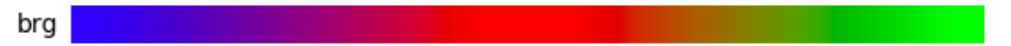

In [47]:
from IPython.display import Image
Image(filename='/content/drive/My Drive/Advanced Machine Learning/brg_scale.png')

In [0]:
from sklearn.decomposition import PCA

In [0]:
#https://stackoverflow.com/questions/38208700/matplotlib-plot-lines-with-colors-through-colormap
#https://matplotlib.org/examples/color/colormaps_reference.html
n = flags.seq_size
colors = plt.cm.brg(np.linspace(0,1,n))

In [0]:
X=c_det_to_pca.cpu().detach().numpy()
nsamples, nx, ny = X.shape
d2_train_dataset = X.reshape((nsamples,nx*ny))


Text(0, 0.5, 'component 2')

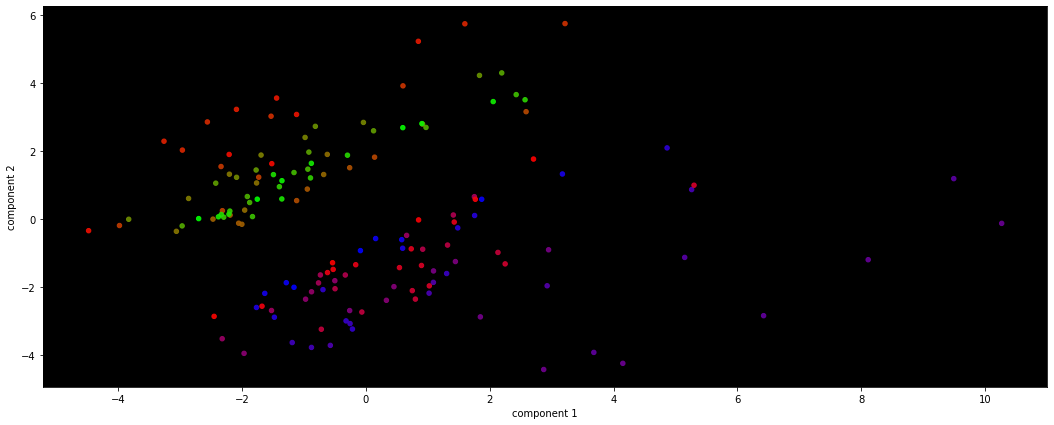

In [51]:

X=d2_train_dataset

pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(X)
plt.figure(figsize=(18, 7))
plt.scatter(projected[:, 0], projected[:, 1],
             #edgecolor='none', 
            alpha=0.9,
              c=colors,s=20)#,
            #cmap=plt.cm.get_cmap('jet'))
ax=plt.axes()
ax.set_facecolor("black")
plt.xlabel('component 1')
plt.ylabel('component 2')
#plt.colorbar();

## Bad data


In [0]:
X3=c_det_bad.cpu().detach().numpy()
nsamples, nx, ny = X3.shape
d2_train_dataset = X3.reshape((nsamples,nx*ny))


Text(0, 0.5, 'component 2')

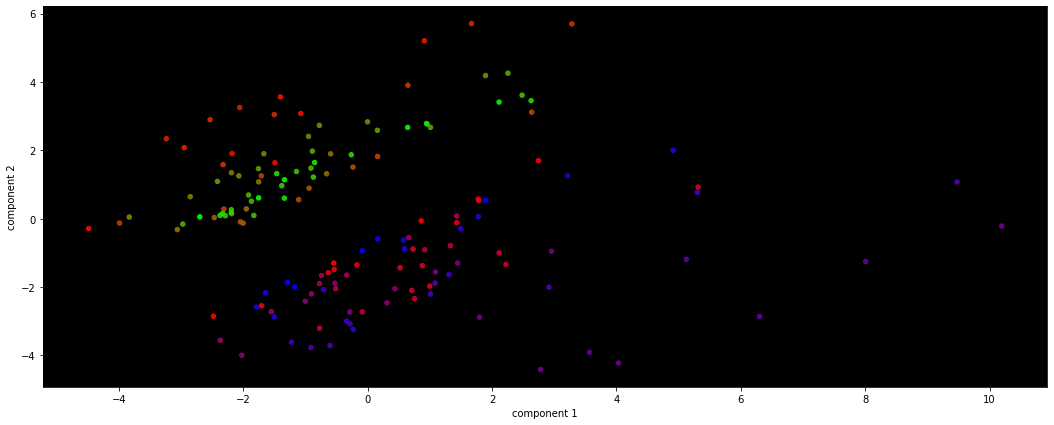

In [53]:

X3=d2_train_dataset

pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(X3)
plt.figure(figsize=(18, 7))
plt.scatter(projected[:, 0], projected[:, 1],
             #edgecolor='none', 
            alpha=0.9,
            s=20
            ,c=colors)#,
            #cmap=plt.cm.get_cmap('Accent', 2))
ax=plt.axes()
ax.set_facecolor("black")
plt.xlabel('component 1')
plt.ylabel('component 2')


## PCA on specific


In [0]:
X3=c_det_to_pca_specific.cpu().detach().numpy()
nsamples, nx, ny = X3.shape
d2_train_dataset = X3.reshape((nsamples,nx*ny))


Text(0, 0.5, 'component 2')

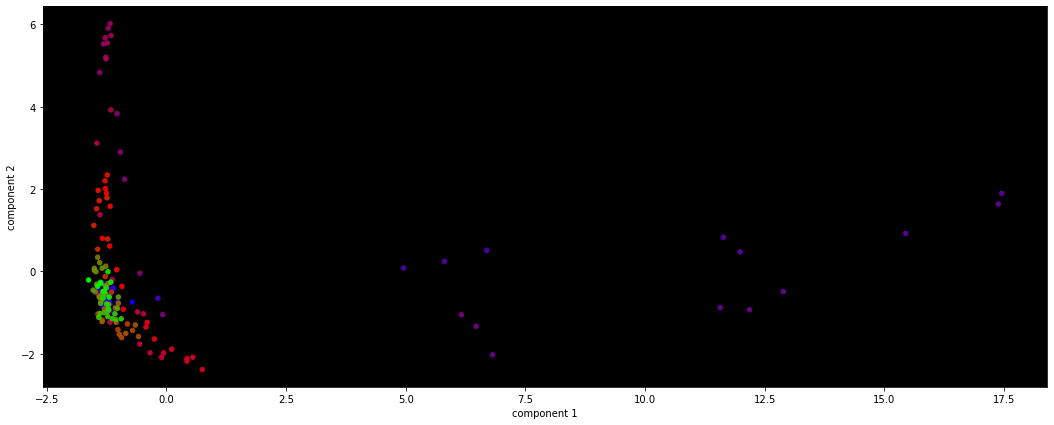

In [55]:

X3=d2_train_dataset

pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(X3)
plt.figure(figsize=(18, 7))
plt.scatter(projected[:, 0], projected[:, 1],
             #edgecolor='none', 
            alpha=0.9,
            s=20
            ,c=colors)#,
            #cmap=plt.cm.get_cmap('Accent', 2))
ax=plt.axes()
ax.set_facecolor("black")
plt.xlabel('component 1')
plt.ylabel('component 2')
